In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train = pd.read_csv('data/mars-train-regr.csv')
test = pd.read_csv('data/mars-public_test-regr.csv')
private_test = pd.read_csv('mars_final_private/mars-private_test-reg.csv')

In [6]:
columns = ['num_test', 'signal_module', 'measure_type', 'num_impulse', 'hor',
           'ver', 'noise', 'azimuth', 'u.m.', 'sec', 'range']
train.columns = columns + ['target']
test.columns = columns
private_test.columns = columns

In [9]:
import os
import random
import numpy as np

# зафиксируем все сиды
DEFAULT_RANDOM_SEED = 17

def set_all_seeds(seed=DEFAULT_RANDOM_SEED):

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_all_seeds(seed=DEFAULT_RANDOM_SEED)

# **catboost baseline**
Валидироваться будем на KFold валидации

In [10]:
X = train[columns]
y = train['target']

cat_feats = ['measure_type', 'num_test']
num_cols = [i for i in train if i not in cat_feats + ['target']]

In [11]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from catboost import CatBoostRegressor, Pool
kfold = KFold(n_splits = 5, shuffle = True, random_state = DEFAULT_RANDOM_SEED)
best_params = {}

def catboost_kfold(kf, X, y, best_params):
    scores = {}
    models = {}
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_pool = Pool(X_train,
                        y_train,
                        cat_features = cat_feats)
        test_pool = Pool(X_test,
                        y_test,
                        cat_features = cat_feats)

        clf = CatBoostRegressor(
            random_state= DEFAULT_RANDOM_SEED,
            loss_function = 'RMSE',
            eval_metric= 'R2',
            depth=6,
            l2_leaf_reg=0.25,
            learning_rate=0.03,
            early_stopping_rounds=200,
            iterations = 7500,
            **best_params
            )

        clf.fit(train_pool,
                eval_set = test_pool,
                verbose = 500)

        scores[i] = clf.best_score_['validation']['R2']
        models[i] = clf


    return scores, models

def get_scores(scores_dict):
    scores = list(scores_dict.values())
    print(f'mean: {np.mean(scores)}, std :{np.std(scores)}')
    print(f'sum: {np.mean(scores) - np.std(scores)}')



In [13]:
scores, models = catboost_kfold(kfold, X, y, best_params)

get_scores(scores)

0:	learn: 0.0056519	test: 0.0047277	best: 0.0047277 (0)	total: 57.8ms	remaining: 7m 13s


KeyboardInterrupt: 

mean: 0.6382192283898028, std :0.011552330657105599
sum: 0.6266668977326972


In [ ]:
def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)

    print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))




In [ ]:
df_feats_imp = plot_importance(
    X,
    best_model = list(models.values()),
    height = 0.20,
    top_n=15,
)

NameError: ignored

In [ ]:
sns.catplot(data = df_feats_imp,
            y = 'feature',
            x = 'importance',
            kind = 'bar')

NameError: ignored

# **EDA**

In [ ]:
def plot_numerical_feature_histogram(df1, df2, feature_title, label=None, text_info=True, bins=50,
                                     figure_width=17, figure_height=7, fontsize=15, number_of_decimals=2, title=''):
    NCOLS_NUMBER_CONST = 1

    if label is None:
        label = feature_title

    fig, ax = plt.subplots(ncols=1, figsize=(figure_width, figure_height))

    sns.histplot(data=df1, x=feature_title, color="cornflowerblue", label=label, bins=bins, kde=True)
    mean_value = df1[feature_title].mean()
    median_value = df1[feature_title].median()
    ax.axvline(x=mean_value, color='black', lw=2, ls=':',
               label=f"mean: {round(mean_value, number_of_decimals)}")
    ax.axvline(x=median_value, color='orange', lw=2, ls='-.',
               label=f"median: {round(median_value, number_of_decimals)}")
    ax.legend(fontsize='15', title_fontsize="10", loc='upper right')
    plt.tight_layout()

    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    Q1 = df1[feature_title].quantile(Q1_QUANTILE_VALUE_CONST)
    Q3 = df1[feature_title].quantile(Q3_QUANTILE_VALUE_CONST)
    IQR = Q3 - Q1

    sns.histplot(data=df2, x=feature_title, color="orange", label=label, bins=bins, kde=True)
    mean_value = df2[feature_title].mean()
    median_value = df2[feature_title].median()
    ax.axvline(x=mean_value, color='green', lw=2, ls=':',
               label=f"mean: {round(mean_value, number_of_decimals)}")
    ax.axvline(x=median_value, color='red', lw=2, ls='-.',
               label=f"median: {round(median_value, number_of_decimals)}")
    ax.legend(fontsize='15', title_fontsize="10", loc='upper right')
    plt.tight_layout()

    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    Q1 = df2[feature_title].quantile(Q1_QUANTILE_VALUE_CONST)
    Q3 = df2[feature_title].quantile(Q3_QUANTILE_VALUE_CONST)
    IQR = Q3 - Q1

    plt.show()

def plot_dataframes_features_info(df1, df2, name):
    print('\n', name, '\n')
    for column in df1.describe().columns:
        plot_numerical_feature_histogram(df1, df2, column, figure_width=10, figure_height=5)


 train vs test 



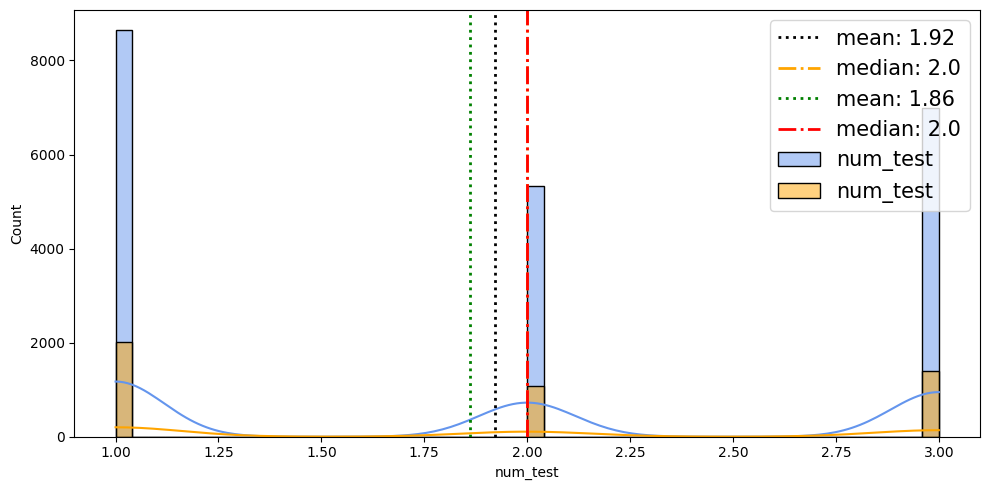

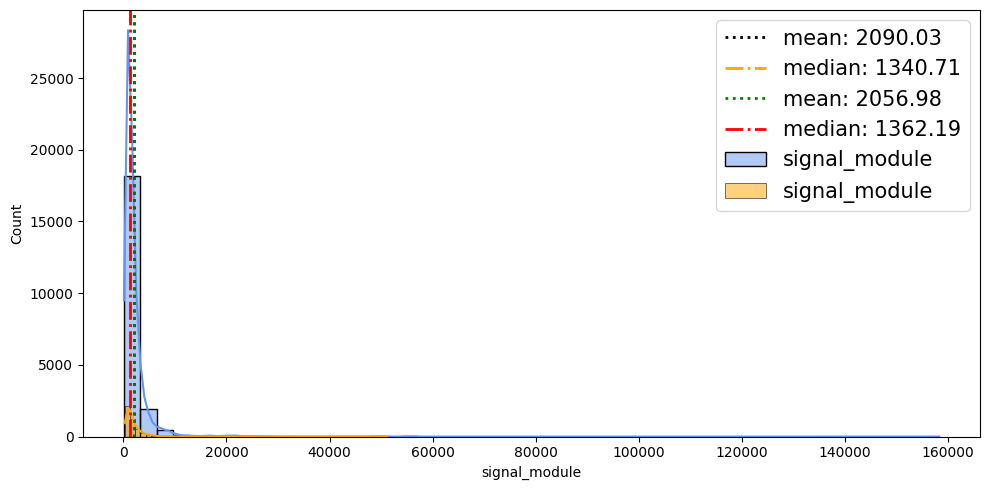

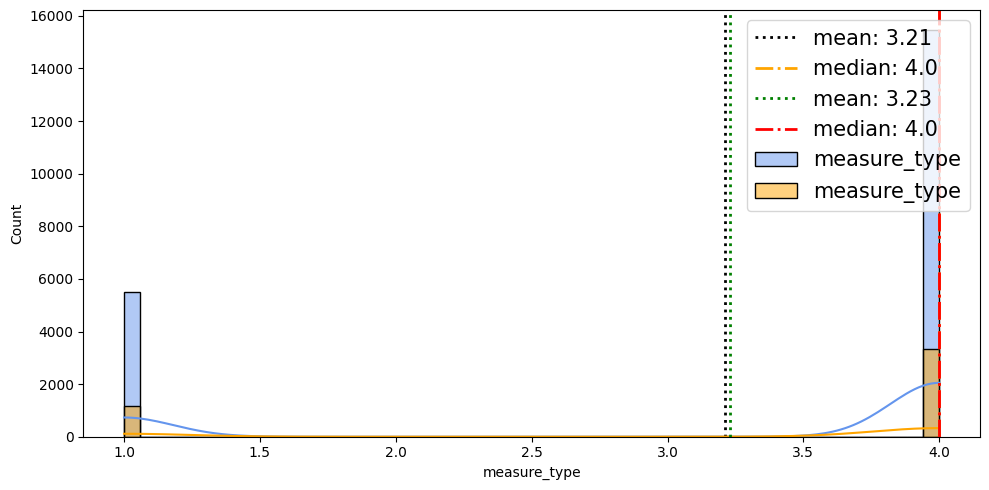

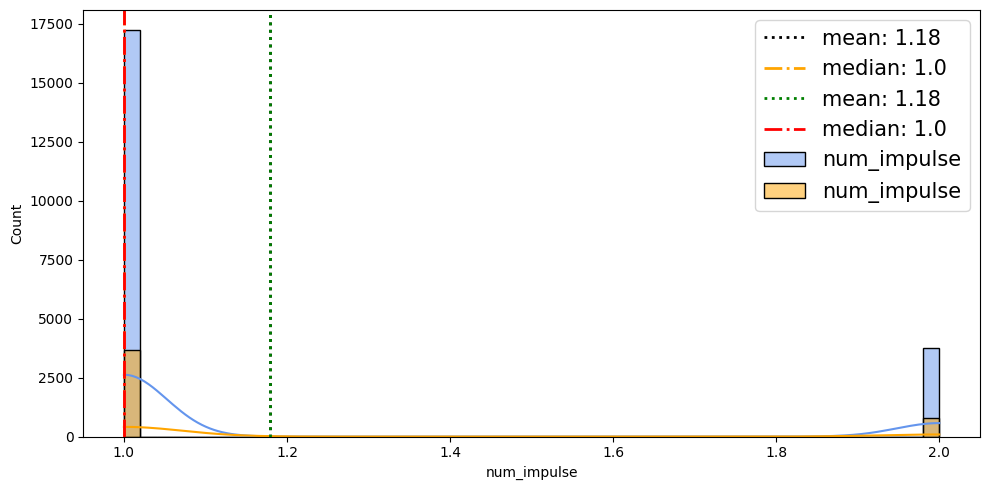

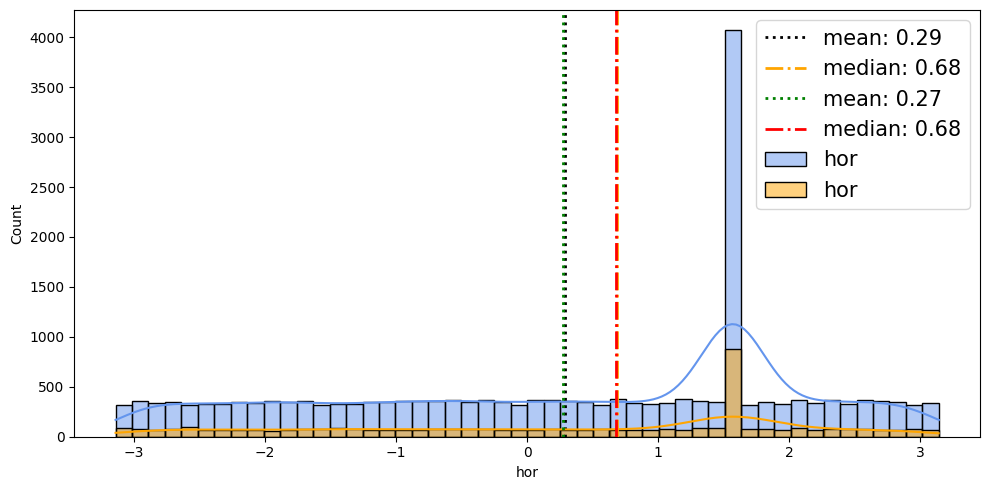

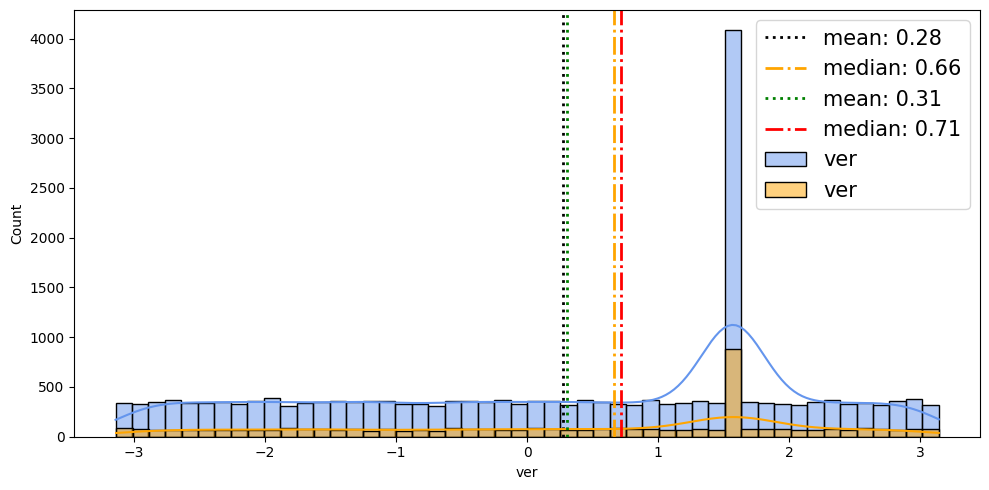

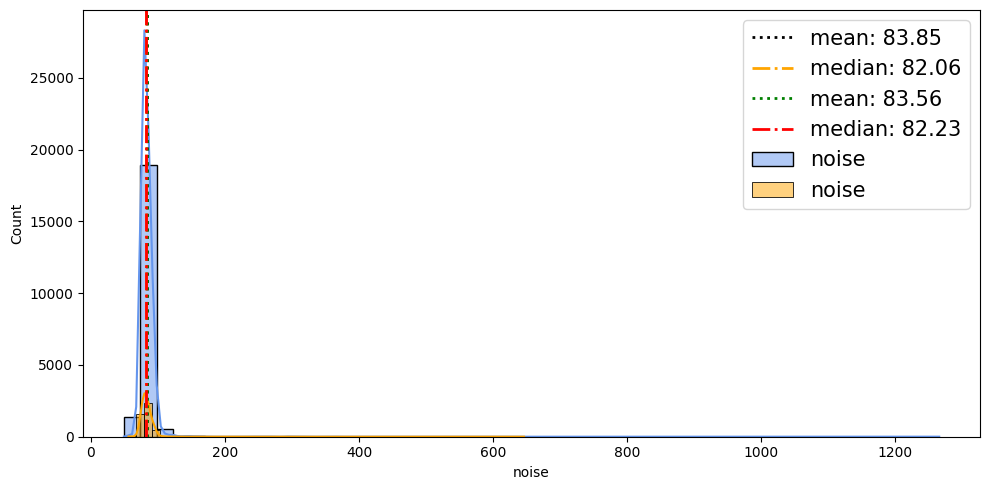

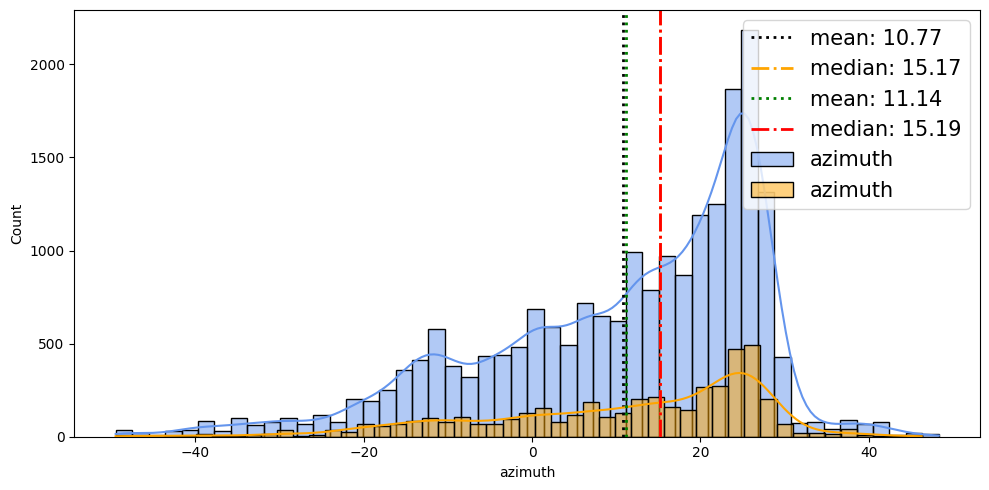

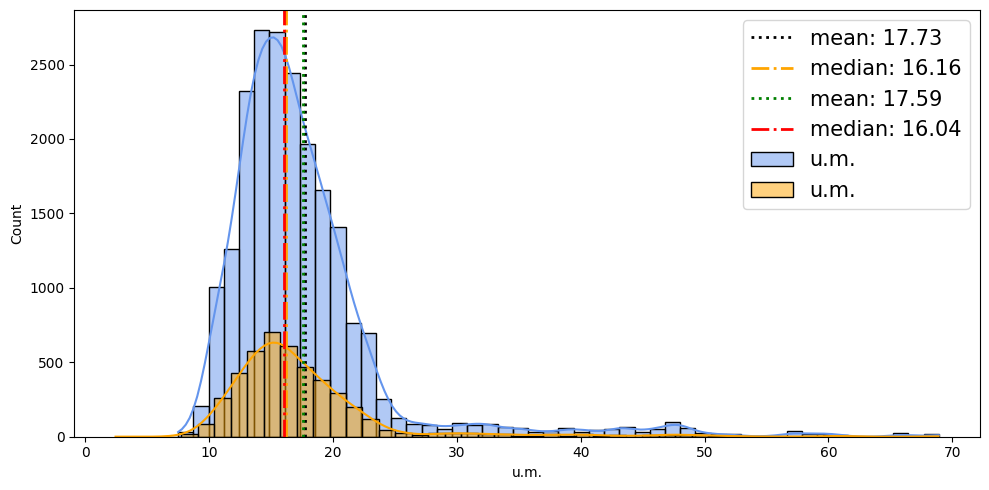

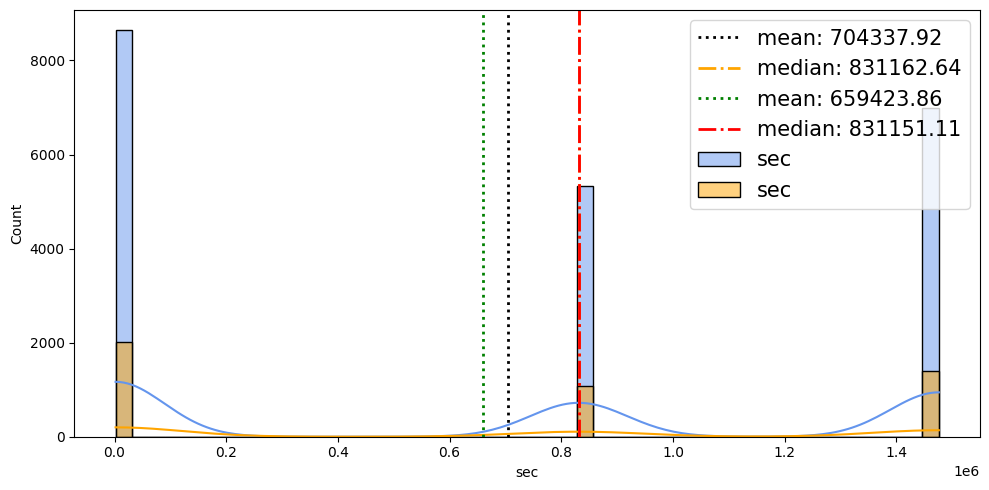

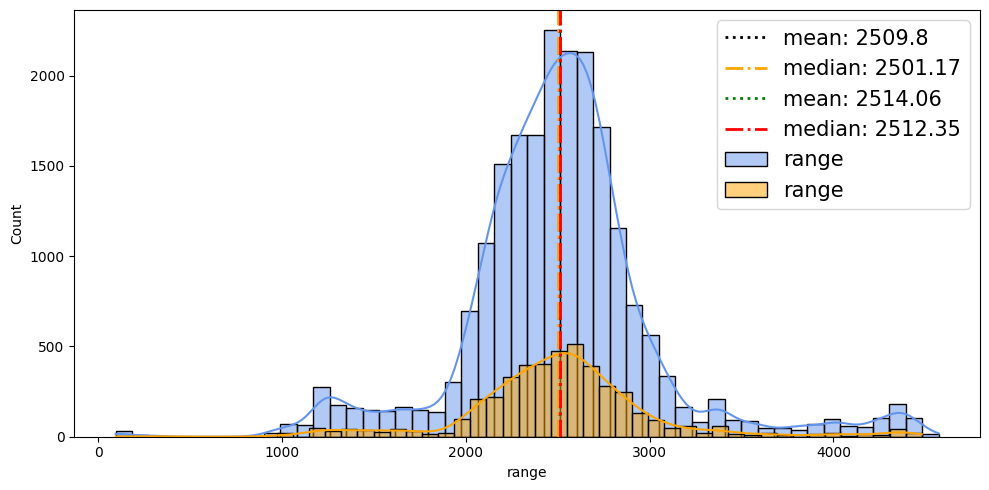

In [ ]:
plot_dataframes_features_info(train[columns], test, 'train vs test')

Видно, что распределения train и test выборки совпадают

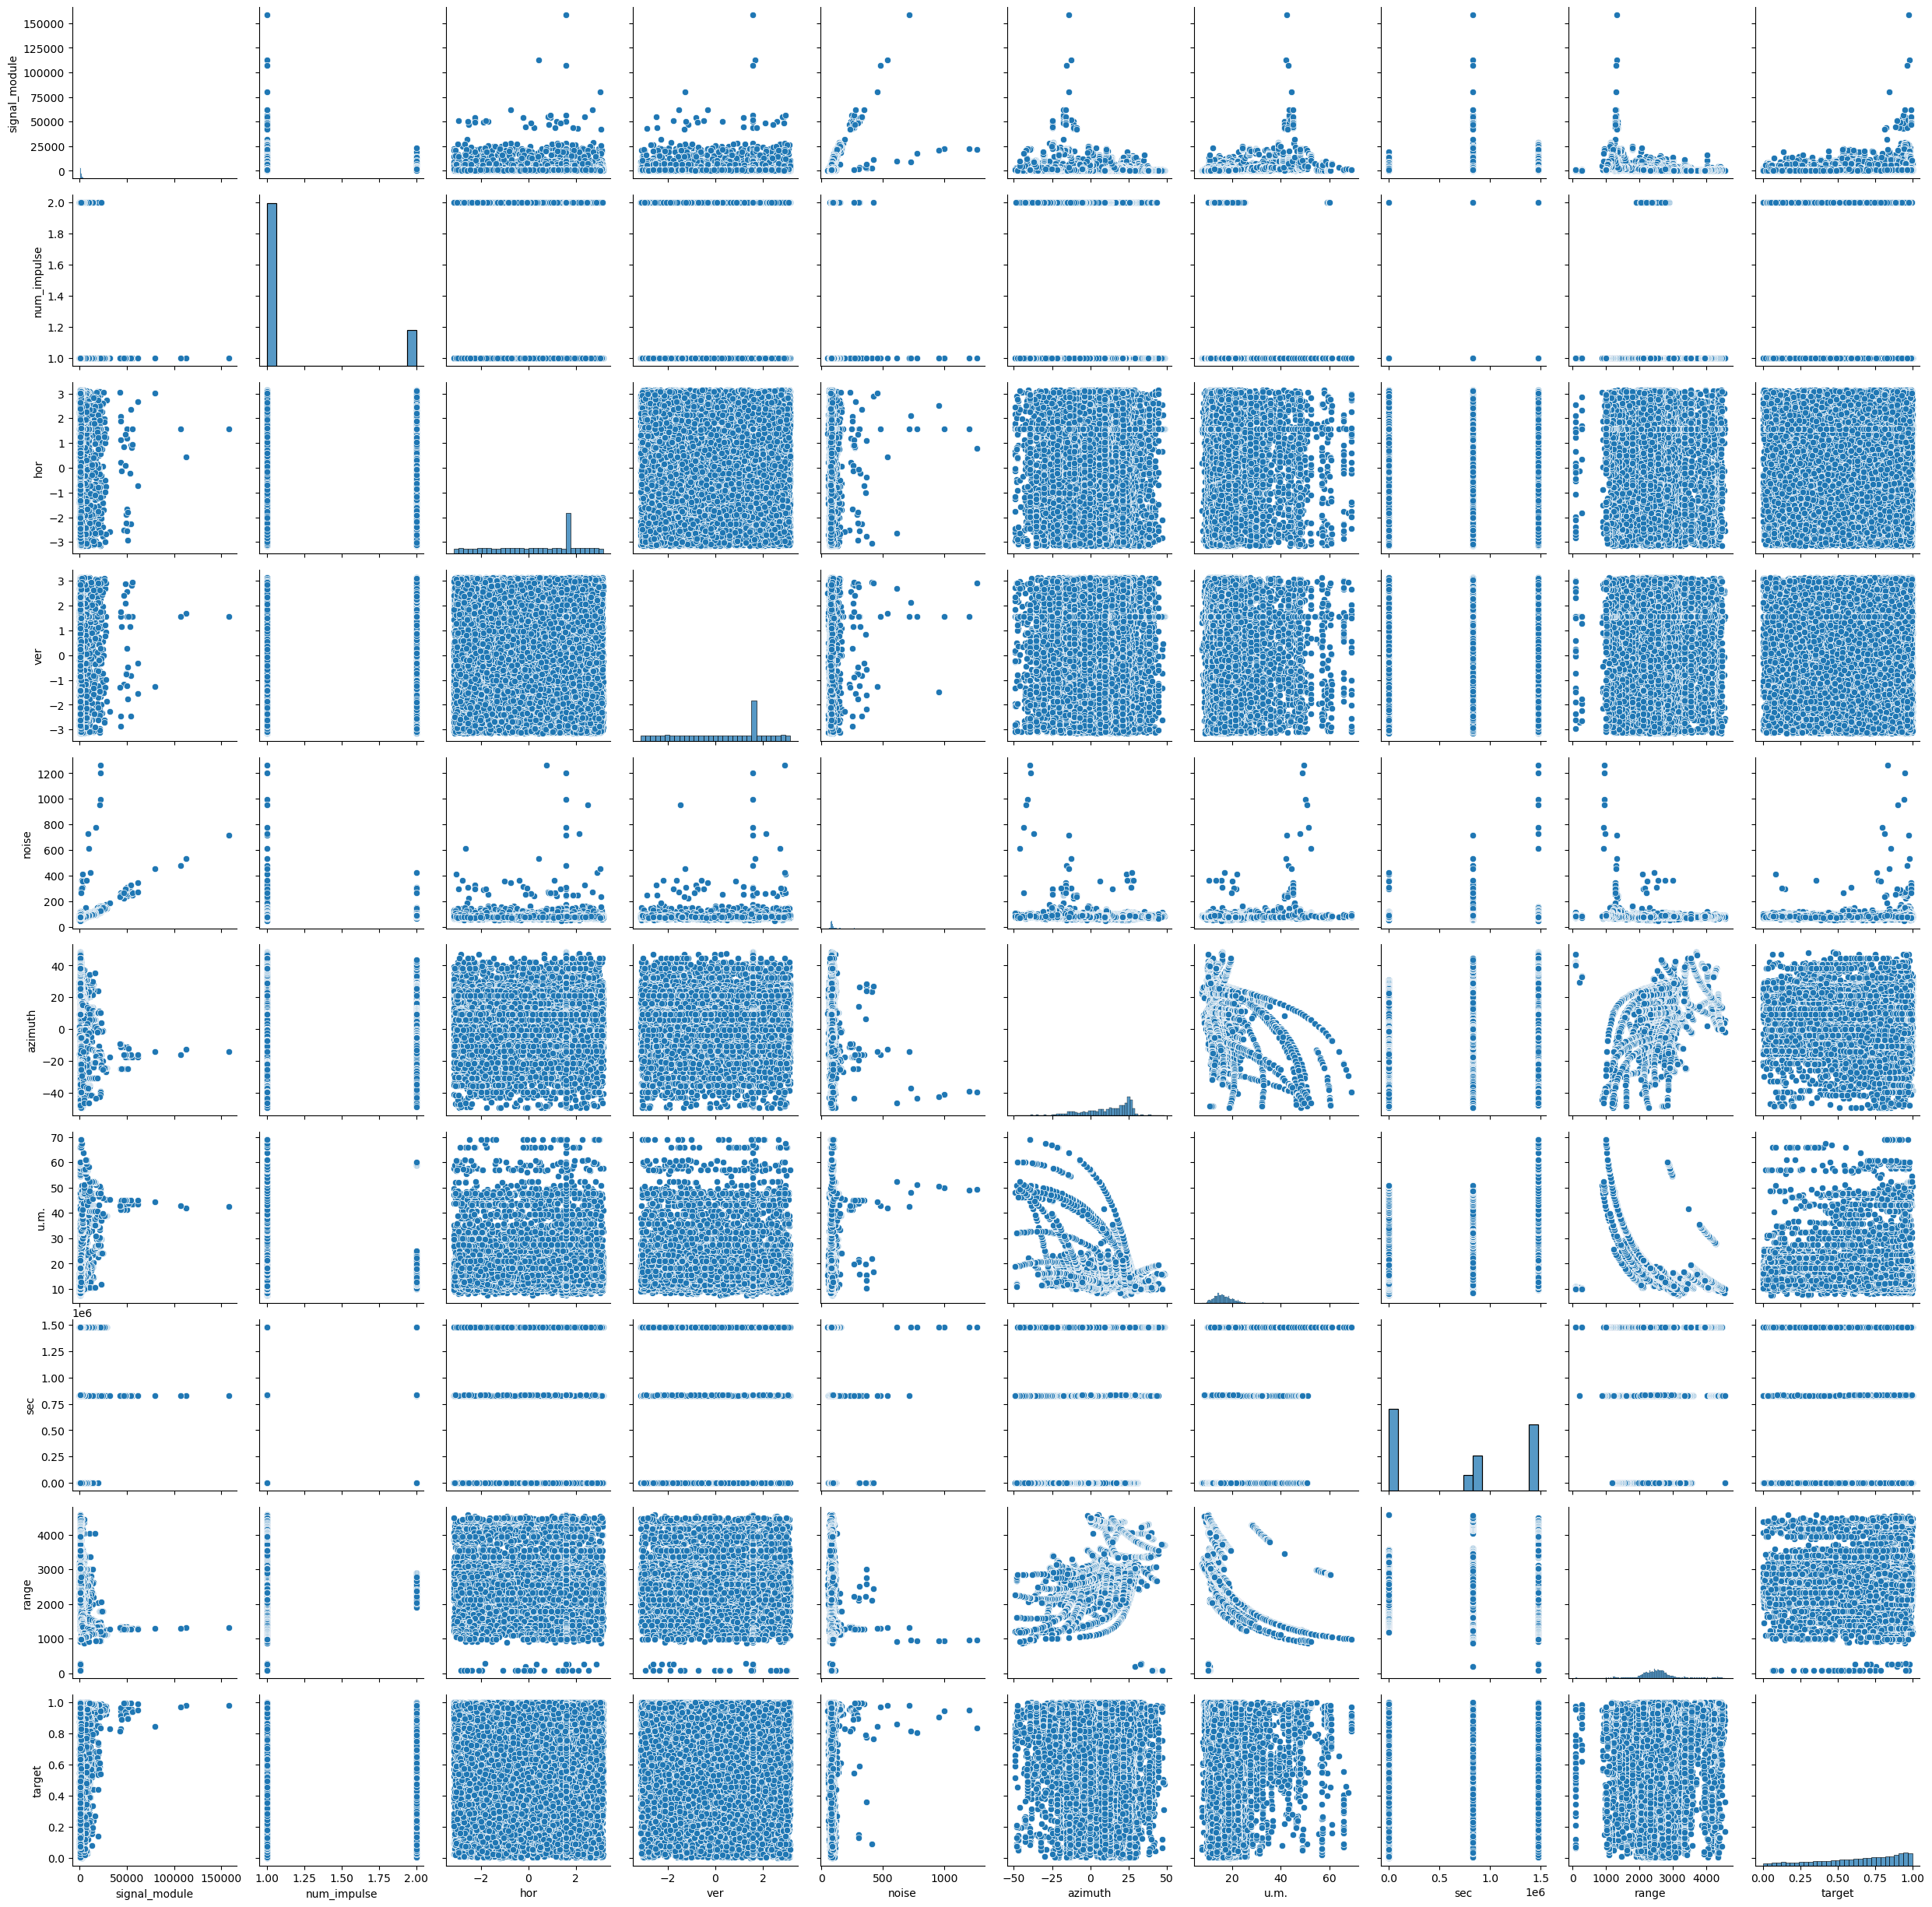

In [14]:
g = sns.PairGrid(train.drop(cat_feats, axis = 1))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

Из пункта Б нам известно, что марсиане летают по одной прямой. Проверим это, изобразив на плоскости (hor,ver) наши данные

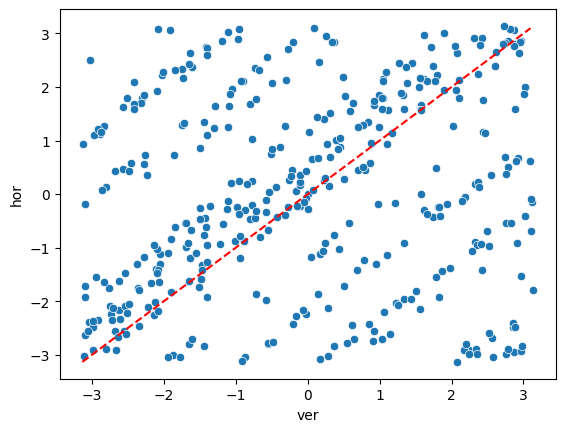

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# посмотрим на срез train выборки за 500 сэмплов
sns.scatterplot(data = train[0:500],
                y = 'hor',
                x = 'ver')
x = np.linspace(min(train.loc[0:300, 'hor']), max(train.loc[0:300, 'hor']), 10)
y_exp = x
plt.plot(x, y_exp, label='Экспонента', linestyle='--', color='red')
plt.show()

действительно, инопланетяне летают по прямым, но hor и ver довольно шумные, поэтому посмотрим на другие признаки

Заметим важную деталь. На графике range - u.m. четко видны паттерны разделяющихся кривых одного вида, но с разным сдвигом. Есть гипотеза о том, что с помощью них можно однозначно определить какой объект находится в поле радара

<Axes: xlabel='u.m.', ylabel='azimuth'>

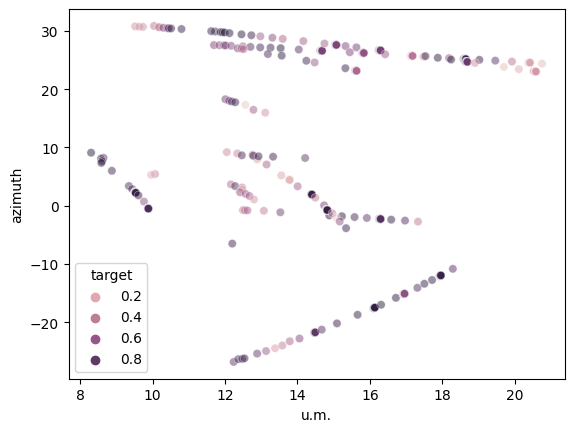

In [ ]:
sns.scatterplot(data = train[0:500],
                x = 'u.m.',
                y = 'azimuth',
                hue = 'target',
                alpha = 0.5)

попробуем посмотреть 3d срез в координатах hor, ver, azimuth.

In [15]:
import plotly.express as px

fig = px.scatter_3d(train.loc[1000:1500],
                    x='u.m.', y='ver', z='azimuth',
                    color='target',
                    )
fig.show()

На графике четко видно разделяющиеся прямые линии, которые по видимому являются передвижениями отдельных марсиан. Но также видно, что на срезе ver = 1.57 появляются странные точки

Также заметим, что, если не учитывать эти отдельные точки, то таргет хорошо выделяется и без признак hor и ver, а отдельные марсиане разделяются проекцией на плоскость (u.m., azimuth)

In [16]:
import plotly.express as px

fig = px.scatter_3d(train.loc[1000:1500],
                    x='hor', y='ver', z='azimuth',
                    color='target',
                    )
fig.show()

Видно, что hor и ver гораздо более шумные, в сравнение с u.m. и azimuth. Поэтому в итоговом обучающем наборе мы удалим эти признаки для лучшего схождения модели к минимуму

In [17]:
import plotly.express as px

fig = px.scatter_3d(train.loc[1000:1500],
                    x='u.m.', y='ver', z='azimuth',
                    color='sec',
                    )
fig.show()

Также мы видим, что sec является очень важным признакам, потому что хорошо разделяет марсиан, но не является идеальным.

В следующем графике видно, что в одно время в поле видимости радара могут пролетать сразу несколько объектов

<Axes: xlabel='sec', ylabel='range'>

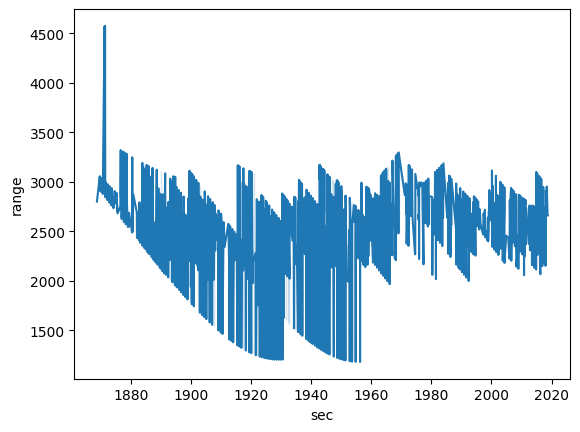

In [ ]:
sns.lineplot(data = train[:5000],
             x = 'sec',
             y = 'range')

далее шли попытки изучить отдельно наблюдения со значениями hor = 1.57, ver = 1.57, но никаких объяснений такому распределению точек найдено не было. Предположительно это могли бы быть выбросы, но поскольку в test выборке они также встречаются, удалять их будет плохой идеей

In [18]:
import plotly.express as px

sliced_train_bad = train[(train.hor >= 1.570796) & (train.hor <= 1.570798) & ((train.ver <= 1.570798)) & (train.ver >= 1.570796)]
sliced_train = train[~((train.hor >= 1.570796) & (train.hor <= 1.570798) & ((train.ver <= 1.570798)) & (train.ver >= 1.570796))]
fig = px.scatter_3d(sliced_train_bad[:500],
                    x='u.m.', y='ver', z='azimuth',
                    color='target',
                    )
fig.show()

In [19]:
fig = px.scatter_3d(sliced_train_bad[:500],
                    x='u.m.', y='sec', z='azimuth',
                    color='target',
                    )
fig.show()

In [20]:
fig = px.scatter_3d(sliced_train[:2000],
                    x='u.m.', y='sec', z='azimuth',
                    color='target',
                    )
fig.show()

In [21]:
import plotly.express as px

fig = px.scatter_3d(sliced_train[100:200],
                    x='u.m.', y='ver', z='azimuth',
                    color='target',
                    )
fig.show()

<Axes: xlabel='sec', ylabel='range'>

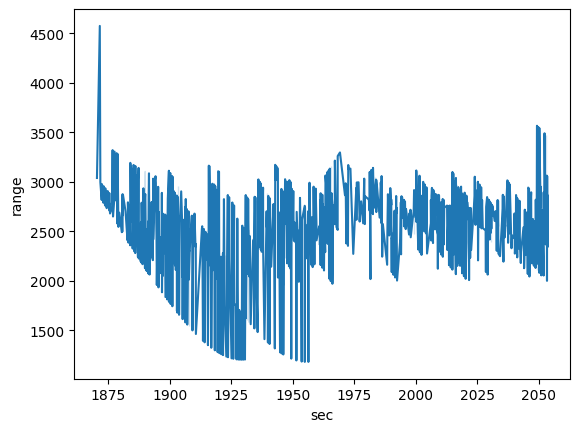

In [ ]:
sns.lineplot(data = sliced_train_bad[:1000],
             x = 'sec',
             y = 'range')

<Axes: xlabel='sec', ylabel='range'>

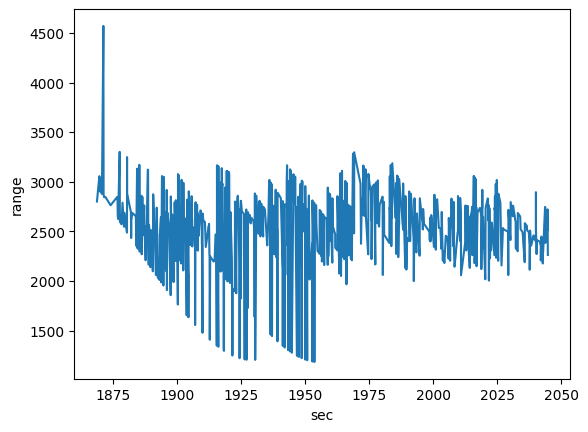

In [ ]:
sns.lineplot(data = sliced_train[:5000],
             x = 'sec',
             y = 'range')

# catboost

Поскольку сами hor и ver не обладают объясняющей способностью и скорее путают модель, то удалим их. Также удалим measure_type и num_impulse, т.к. по feature importance они находятся ниже всего

In [ ]:
new_train = train.drop(['measure_type', 'num_impulse'], axis = 1)
new_test = test.drop(['hor', 'ver', 'measure_type', 'num_impulse'], axis = 1)

# выкинем hor и ver
new_train.drop(['hor', 'ver'], axis = 1, inplace = True)
cat_feats = ['num_test']
X = new_train.drop('target', axis = 1)
y = new_train['target']
X

num_test  signal_module       noise    azimuth       u.m.  \
0             1        470.071  102.693716  -6.514675  12.200567   
1             1        908.170   83.533212 -26.816982  12.239598   
2             1       1516.590   85.718564  27.560049  11.695174   
3             1       5478.080   89.123510  29.888658  11.727221   
4             1       1464.070   89.232579  27.540041  11.842715   
...         ...            ...         ...        ...        ...   
20960         3        856.200   78.541804  21.012567  21.202597   
20961         3        723.650   70.837544  21.012123  21.204919   
20962         3        900.330   75.481914  21.011615  21.207249   
20963         3        817.340   79.448071  21.011107  21.209584   
20964         3        930.480   79.154575  21.010090  21.214244   

                sec        range  
0      1.868779e+03  2800.056250  
1      1.869714e+03  3055.921963  
2      1.869770e+03  2940.934511  
3      1.869798e+03  2912.276979  
4      1.869952e+03  2934.124901  
...             ...          ...  
20960  1.476154e+06  2126.139735  
20961  1.476154e+06  2125.996804  
20962  1.476154e+06  2125.843665  
20963  1.476154e+06  2125.690525  
20964  1.476154e+06  2125.394455  

[20965 rows x 7 columns]

In [ ]:
scores, models = catboost_kfold(kfold, X, y, best_params)

0:	learn: 0.0062548	test: 0.0055270	best: 0.0055270 (0)	total: 74ms	remaining: 9m 14s
500:	learn: 0.4121973	test: 0.3821757	best: 0.3821757 (500)	total: 5.15s	remaining: 1m 11s
1000:	learn: 0.5577691	test: 0.5074991	best: 0.5074991 (1000)	total: 9.65s	remaining: 1m 2s
1500:	learn: 0.6411295	test: 0.5743180	best: 0.5743180 (1500)	total: 16.6s	remaining: 1m 6s
2000:	learn: 0.6956656	test: 0.6125850	best: 0.6125978 (1999)	total: 21.1s	remaining: 58.1s
2500:	learn: 0.7368136	test: 0.6396602	best: 0.6396602 (2500)	total: 26.8s	remaining: 53.5s
3000:	learn: 0.7674688	test: 0.6577558	best: 0.6577558 (3000)	total: 33.7s	remaining: 50.6s
3500:	learn: 0.7912905	test: 0.6709107	best: 0.6709107 (3500)	total: 38.3s	remaining: 43.8s
4000:	learn: 0.8114168	test: 0.6809071	best: 0.6809161 (3997)	total: 45.4s	remaining: 39.7s
4500:	learn: 0.8284128	test: 0.6885213	best: 0.6885213 (4500)	total: 50s	remaining: 33.3s
5000:	learn: 0.8425844	test: 0.6934140	best: 0.6934199 (4998)	total: 55.6s	remaining: 27.

In [ ]:
scores, get_scores(scores)

mean: 0.7032801978996063, std :0.007216382237442106
sum: 0.6960638156621641


({0: 0.707349382826954,
  1: 0.6947719366292193,
  2: 0.7091049999659594,
  3: 0.6943246584085541,
  4: 0.7108500116673446},
 None)

Сохраним модели по фолдам, а также запомним модель с самым лучшим скором

In [ ]:
for key, model in models.items():
    model.save_model(f'/content/drive/MyDrive/rucode/marsians/models/catboost_fold{key}')

best_catboost = models[4].save_model(f'/content/drive/MyDrive/rucode/marsians/models/best_catboost')

In [ ]:
preds = []

for catboost_i in models.values():
    preds.append(catboost_i.predict(new_test))
catboost_pred_by_fold = np.mean(preds, axis = 0)
subm_file = pd.read_csv(PATH + 'mars-public_test-regr.csv')
subm_file['Доля сигнала в ВП'] = np.mean(preds, axis = 0)

subm_file.to_csv('subm_catboost.csv', index = False)
subm_file.head()

№ испытания  Модуль сигнала  Тип_измерения  Количество импульсов  Фаза Hor  \
0            1         2228.58              1                     2 -1.296037   
1            1         1886.45              1                     2  1.570796   
2            1         2015.85              1                     2  1.570796   
3            1        11495.21              1                     2  1.570796   
4            1         1595.66              1                     2  1.570796   

   Фаза Ver  Уровень шума     Азимут       У.М.      Секунда  Дальность (м)  \
0 -0.823444     95.340461   8.576654  12.988322  1874.687195    2789.785685   
1  1.570796     96.199134  26.927104  13.798552  1874.784974    2734.624786   
2  1.570796     87.818645   8.393800  12.966248  1874.882752    2785.661124   
3  1.570796     71.244075  28.437188  13.875287  1874.952594    2706.620650   
4  1.570796     82.509944   8.252281  12.861609  1875.092277    2781.097562   

   Доля сигнала в ВП  
0           0.633866  
1           0.622367  
2           0.682318  
3           0.817519  
4           0.494106

Всего признаков 9 Усреднее по 5-ти моделям: 
На график нанесено топ-15 признаков


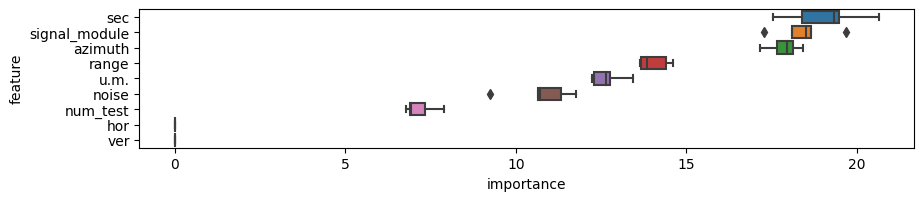

In [ ]:
df_feats_imp = plot_importance(
    X,
    best_model = list(models.values()),
    height = 0.20,
    top_n=15,
)

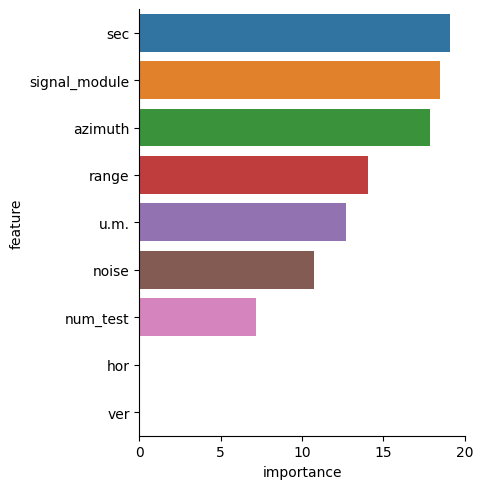

In [ ]:
sns.catplot(data = df_feats_imp,
            y = 'feature',
            x = 'importance',
            kind = 'bar')

In [ ]:
pip install shap >> None

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


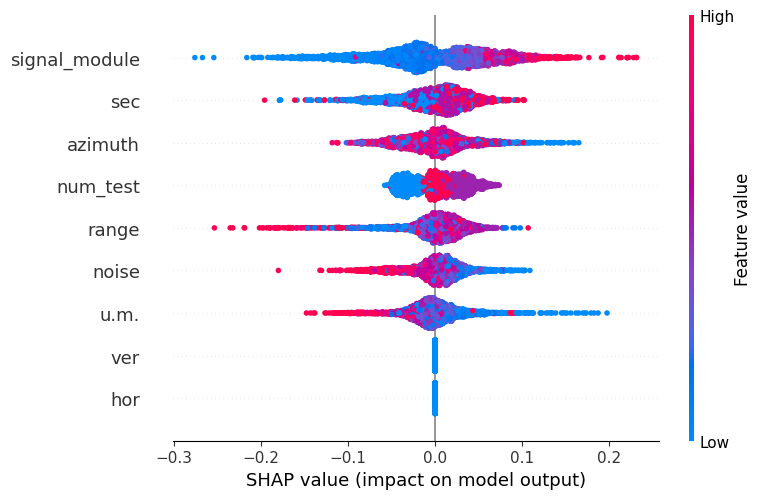

In [ ]:
import shap

explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

# **LightGBM**

In [ ]:
from lightgbm import LGBMRegressor, Dataset
from lightgbm import train as Train
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [ ]:
gridParams = {
    'learning_rate': [0.07],
    'n_estimators' : [2000],
    'max_bin' : [500],
    'lambda_l1': [0.1],
    'lambda_l2':[0.05]}


indexes_of_categories = [X.columns.get_loc(col) for col in cat_feats]

lgbm_model = LGBMRegressor(
                           objective= 'RMSE',
                           eval = 'R2',
                           verbose=-1,
                           random_state = DEFAULT_RANDOM_SEED)
gsearch = GridSearchCV(estimator=lgbm_model,
                       param_grid=gridParams,
                       cv= kfold,
                       verbose=500,
                      )
fit_params = {'categorical_feature':indexes_of_categories}
gsearch.fit(X, y, **fit_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START lambda_l1=0.1, lambda_l2=0.05, learning_rate=0.07, max_bin=500, n_estimators=2000


KeyboardInterrupt: ignored

In [ ]:
lgbm_best_params = {'lambda_l1': 0.1,
  'lambda_l2': 0.05,
  'learning_rate': 0.07,
  'max_bin': 500,
  'n_estimators': 4000,
   'random_state': DEFAULT_RANDOM_SEED}
lgbm_best_params['early_stopping_rounds'] = 200

In [ ]:
from sklearn.metrics import r2_score

def lgbm_cv(kf, X, best_params, cat_feats):
    lgbm_by_fold = {}
    lgbm_scores = {}

    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Dataset(X_train,
                        y_train,
                        categorical_feature = cat_feats,
                        )
        test_dataset = Dataset(X_test,
                        y_test,
                        categorical_feature = cat_feats,
                        )

        lgbmf = Train(params = best_params,
                    train_set = train_dataset,
                    valid_sets = (test_dataset),
                    )
        test_preds = lgbmf.predict(X_test)
        print("Test R2: %.2f" % r2_score(y_test, test_preds) )
        lgbm_by_fold[i] = lgbmf
        lgbm_scores[i] = r2_score(y_test, test_preds)

    return lgbm_scores, lgbm_by_fold


In [ ]:
lgbm_scores, lgbm_by_fold = lgbm_cv(kfold, X, lgbm_best_params,cat_feats)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 16772, number of used features: 7
[LightGBM] [Info] Start training from score 0.640285
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2162]	valid_0's l2: 0.0212126
Test R2: 0.72
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 16772, number of used features: 7
[LightGBM] [Info] Start training from score 0.638843
Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Early stopping, best iteration is:
[2101]	valid_0's l2: 0.0220333
Test R2: 0.70
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 16772, number of used features: 7
[LightGBM] [Info] Start training from score 0.639967
Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Early stopping, best iteration is:
[2039]	valid_0's l2: 0.0209625
Test R2: 0.72
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 16772, number of used features: 7
[LightGBM] [Info] Start training from score 0.638724
Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Early stopping, best iteration is:
[1572]	valid_0's l2: 0.0216489
Test R2: 0.70
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 16772, number of used features: 7
[LightGBM] [Info] Start training from score 0.637086
Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Early stopping, best iteration is:
[1344]	valid_0's l2: 0.0200628
Test R2: 0.72


In [ ]:
get_scores(lgbm_scores), lgbm_scores

mean: 0.7108415573929385, std :0.009007158261174333
sum: 0.7018343991317642


(None,
 {0: 0.7170880613756092,
  1: 0.6980339002941703,
  2: 0.7185864782744691,
  3: 0.7018263382200399,
  4: 0.7186730088004039})

In [ ]:
# сохраним модели
for key, model in lgbm_by_fold.items():
    model.save_model(f'/content/drive/MyDrive/rucode/marsians/models/lgbm_fold{key}')

best_lgbm = lgbm_by_fold[2].save_model(f'/content/drive/MyDrive/rucode/marsians/models/best_lgbm.txt')

In [ ]:
preds = []

for lgbm_i in lgbm_by_fold.values():
    preds.append(lgbm_i.predict(new_test))
lgbm_pred_by_fold = np.mean(preds, axis = 0)
subm_file = pd.read_csv(PATH + 'mars-public_test-regr.csv')
subm_file['Доля сигнала в ВП'] = np.mean(preds, axis = 0)

subm_file.to_csv('subm_lgbm_dropedrows.csv', index = False)
subm_file.head()

№ испытания  Модуль сигнала  Тип_измерения  Количество импульсов  Фаза Hor  \
0            1         2228.58              1                     2 -1.296037   
1            1         1886.45              1                     2  1.570796   
2            1         2015.85              1                     2  1.570796   
3            1        11495.21              1                     2  1.570796   
4            1         1595.66              1                     2  1.570796   

   Фаза Ver  Уровень шума     Азимут       У.М.      Секунда  Дальность (м)  \
0 -0.823444     95.340461   8.576654  12.988322  1874.687195    2789.785685   
1  1.570796     96.199134  26.927104  13.798552  1874.784974    2734.624786   
2  1.570796     87.818645   8.393800  12.966248  1874.882752    2785.661124   
3  1.570796     71.244075  28.437188  13.875287  1874.952594    2706.620650   
4  1.570796     82.509944   8.252281  12.861609  1875.092277    2781.097562   

   Доля сигнала в ВП  
0           0.627247  
1           0.538892  
2           0.748842  
3           0.714946  
4           0.580524

на паблике выбила 47.82269

# XGBoost

In [ ]:
from xgboost import XGBRegressor, DMatrix
from xgboost import plot_importance as xgb_plot_importance
from xgboost import train as xgb_train

In [ ]:
X_xgb = X.copy()
X_xgb[cat_feats] = X_xgb[cat_feats].astype('category')
X_xgb.drop('num_test', axis = 1, inplace = True) # выкинем num_test, поскольку fi показало плохую оценку

In [ ]:
from sklearn.metrics import r2_score

xgb_model = XGBRegressor(tree_method="hist",
                       enable_categorical=True,
                       use_rmm = True,
                       eval_metric = r2_score)

xgb_params = {
        'min_child_weight': [5],
        'gamma': [0],
        'subsample': [1.0],
        'eta':[0.25],
        'colsample_bytree': [0.6],
        'max_depth': [10],
        'lambda': [1.5],
        'alpha': [0.5],
        'max_bin': [2000]
        }

gridsearch_xgb = GridSearchCV(xgb_model,
                                 param_grid=xgb_params,
                                   scoring='r2',
                                   cv=kfold,
                                   verbose=500,
                                   )
gridsearch_xgb.fit(X_xgb, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START alpha=0.5, colsample_bytree=0.6, eta=0.25, gamma=0, lambda=1.5, max_bin=2000, max_depth=10, min_child_weight=5, subsample=1.0


KeyboardInterrupt: ignored

In [ ]:
gridsearch_xgb.best_score_, gridsearch_xgb.best_params_

(0.6991081476211037,
 {'alpha': 0.5,
  'colsample_bytree': 0.6,
  'eta': 0.25,
  'gamma': 0,
  'lambda': 1.5,
  'max_bin': 3500,
  'max_depth': 10,
  'min_child_weight': 5,
  'subsample': 1.0})

In [ ]:
best_params_xgb = {'alpha': 0.5,
                    'colsample_bytree': 0.6,
                    'eta': 0.25,
                    'gamma': 0,
                    'lambda': 1.5,
                    'max_bin': 3500,
                    'max_depth': 10,
                    'min_child_weight': 5,
                    'subsample': 1.0,
                    'seed': DEFAULT_RANDOM_SEED
                    }

In [ ]:
def my_r2(predt, dtrain):
    y = dtrain.get_label()
    r2 = 1 - np.sum((y - predt) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return 'R2', r2

def xgb_kfold(X, y, kf, xgb_params):
    xgb_by_fold = {}
    xgb_scores = {}
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        X_train, y_train = X.iloc[train_index], y[train_index]
        X_test, y_test = X.iloc[test_index], y[test_index]

        train_dmatrix = DMatrix(X_train,
                                label = y_train,
                                nthread=-1,
                                enable_categorical = True)
        test_dmatrix = DMatrix(X_test,
                        y_test,
                        nthread=-1,
                        enable_categorical=True)

        xgb_model = xgb_train(xgb_params,
                        dtrain=train_dmatrix,
                        num_boost_round=3000,
                        evals=[ (test_dmatrix, 'dtest')],
                        early_stopping_rounds=200,
                        verbose_eval=100,
                        custom_metric=my_r2)


        test_preds = xgb_model.predict(test_dmatrix)
        print("Test R2: %.5f" % r2_score(y_test, test_preds))
        xgb_by_fold[i] = xgb_model
        xgb_scores[i] = r2_score(y_test, test_preds)
    return xgb_by_fold, xgb_scores

In [ ]:
models_xgb, scores_xgb = xgb_kfold(X_xgb, y, kfold, best_params_xgb)

[0]	dtest-rmse:0.26977	dtest-R2:0.02940
[100]	dtest-rmse:0.14630	dtest-R2:0.71456
[200]	dtest-rmse:0.14426	dtest-R2:0.72243
Test R2: 0.72243
[0]	dtest-rmse:0.27322	dtest-R2:-0.02310
[100]	dtest-rmse:0.14891	dtest-R2:0.69610
[200]	dtest-rmse:0.14676	dtest-R2:0.70482
Test R2: 0.70482
[0]	dtest-rmse:0.27327	dtest-R2:-0.00250
[100]	dtest-rmse:0.14418	dtest-R2:0.72094
[199]	dtest-rmse:0.14294	dtest-R2:0.72572
Test R2: 0.72583
[0]	dtest-rmse:0.26877	dtest-R2:0.00507
[100]	dtest-rmse:0.14722	dtest-R2:0.70149
[199]	dtest-rmse:0.14547	dtest-R2:0.70854
Test R2: 0.70867
[0]	dtest-rmse:0.27106	dtest-R2:-0.03028
[100]	dtest-rmse:0.14142	dtest-R2:0.71956
[199]	dtest-rmse:0.13961	dtest-R2:0.72669
Test R2: 0.72672


In [ ]:
get_scores(scores_xgb)

mean: 0.7064062385424817, std :0.008825971428799201
sum: 0.6975802671136826


In [ ]:
get_scores(scores_xgb)

mean: 0.7176950579257084, std :0.00913768321071066
sum: 0.7085573747149978


In [ ]:
preds = []
test_dmatrix = DMatrix(new_test.drop('num_test', axis = 1))
for xgb_model in models_xgb.values():
    preds.append(xgb_model.predict(test_dmatrix))
xgb_pred_by_fold = np.mean(preds, axis = 0)
subm_file = pd.read_csv(PATH + 'mars-public_test-regr.csv')
subm_file['Доля сигнала в ВП'] = xgb_pred_by_fold

subm_file.to_csv('subm_xgb.csv', index = False)
subm_file.head()

№ испытания  Модуль сигнала  Тип_измерения  Количество импульсов  Фаза Hor  \
0            1         2228.58              1                     2 -1.296037   
1            1         1886.45              1                     2  1.570796   
2            1         2015.85              1                     2  1.570796   
3            1        11495.21              1                     2  1.570796   
4            1         1595.66              1                     2  1.570796   

   Фаза Ver  Уровень шума     Азимут       У.М.      Секунда  Дальность (м)  \
0 -0.823444     95.340461   8.576654  12.988322  1874.687195    2789.785685   
1  1.570796     96.199134  26.927104  13.798552  1874.784974    2734.624786   
2  1.570796     87.818645   8.393800  12.966248  1874.882752    2785.661124   
3  1.570796     71.244075  28.437188  13.875287  1874.952594    2706.620650   
4  1.570796     82.509944   8.252281  12.861609  1875.092277    2781.097562   

   Доля сигнала в ВП  
0           0.520957  
1           0.531017  
2           0.598055  
3           0.630216  
4           0.448813

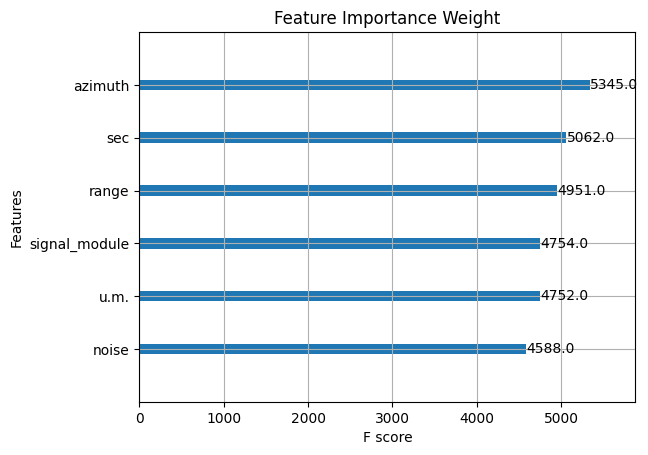

In [ ]:
xgb_plot_importance(models_xgb[2], title='Feature Importance Weight');

Скор на паблике: 48.44

сохраним модели

In [ ]:
scores_xgb

{0: 0.7224312584529866,
 1: 0.7048193107856631,
 2: 0.7258342159525559,
 3: 0.7086668548252754,
 4: 0.726723649612061}

In [ ]:
import pickle
for i in models_xgb:
    with open(f'/content/drive/MyDrive/rucode/marsians/models/xgb_model_{i}.pkl', 'wb') as f:
        pickle.dump(models_xgb[i], f)

best_xgb = models_xgb[4]
with open(f'/content/drive/MyDrive/rucode/marsians/models/best_xgb.pkl', 'wb') as f:
        pickle.dump(models_xgb[4], f)

# Stacking
попробуем застакать с помощью метамодели xgboost, catboost и lightgbm с подобранным параметрами. Для этого будем использовать pipeline из sklearn

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

In [ ]:
# предикт xgboost

(xgb_pred_by_fold + catboost_pred_by_fold + lgbm_pred_by_fold)/3

array([0.59402318, 0.56409205, 0.67640509, ..., 0.80446929, 0.7826248 ,
       0.83672623])

In [ ]:
koef = 1/(46.75517 + 47.82269 + 48.44284)
catboost_koef = koef*46.75517
lgbm_koef = koef*47.82269
xgb_koef = koef*48.44284

blending_pred = xgb_pred_by_fold*xgb_koef + catboost_pred_by_fold*catboost_koef + lgbm_pred_by_fold*lgbm_koef
blending_pred

array([0.59340897, 0.56351367, 0.67602123, ..., 0.80472909, 0.7830609 ,
       0.83679818])

In [ ]:
subm_file = pd.read_csv(PATH + 'mars-public_test-regr.csv')
subm_file['Доля сигнала в ВП'] = blending_pred

subm_file.to_csv('blending_subm.csv', index = False)
subm_file.head()

№ испытания  Модуль сигнала  Тип_измерения  Количество импульсов  Фаза Hor  \
0            1         2228.58              1                     2 -1.296037   
1            1         1886.45              1                     2  1.570796   
2            1         2015.85              1                     2  1.570796   
3            1        11495.21              1                     2  1.570796   
4            1         1595.66              1                     2  1.570796   

   Фаза Ver  Уровень шума     Азимут       У.М.      Секунда  Дальность (м)  \
0 -0.823444     95.340461   8.576654  12.988322  1874.687195    2789.785685   
1  1.570796     96.199134  26.927104  13.798552  1874.784974    2734.624786   
2  1.570796     87.818645   8.393800  12.966248  1874.882752    2785.661124   
3  1.570796     71.244075  28.437188  13.875287  1874.952594    2706.620650   
4  1.570796     82.509944   8.252281  12.861609  1875.092277    2781.097562   

   Доля сигнала в ВП  
0           0.593409  
1           0.563514  
2           0.676021  
3           0.719779  
4           0.507661